In [497]:
import scipy.io

import os
import time

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
from scipy import stats

In [498]:
mat = scipy.io.loadmat('Oxford_Battery_Degradation_Dataset_1.mat')

In [499]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Cell1', 'Cell2', 'Cell3', 'Cell4', 'Cell5', 'Cell6', 'Cell7', 'Cell8'])

In [500]:
input_data = [
    [[], []],
    [[], []],
    [[], []],
    [[], []],
    [[], []]
]

In [501]:
for i in range(0, 83):
    if (i < 10):
        if (i == 0):
            temp = "cyc0000"
        else:
            temp = "cyc0" + str(i) + "00"
    else:
        temp = "cyc" + str(i) + "00"
    try:
        curr = mat["Cell1"][0][temp][0][0]["C1ch"][0][0]['q'][0][-1][0]
    except ValueError:
        curr = float("NaN")
    input_data[0][0].append(i)
    input_data[0][1].append(curr)
    print(curr)

724.1208914093187
714.5350426825697
709.8543464961379
707.0393485194566
702.2342863457235
698.8440013150872
695.4850715278354
691.6932258285015
687.6300422440017
684.2488065128581
681.0607272448832
677.8486336050008
674.7281887527703
671.556081370731
668.6709791990864
nan
662.9724287937147
nan
656.4621886431951
653.2751603988444
650.1157422984008
647.1105116933119
644.0549444561768
640.7948747304991
638.1391374235501
635.3790871886936
632.3887851445143
629.9572173218418
627.3439847566834
624.1095617381898
622.448908879052
619.9778349196439
617.3031788485108
615.3476618618469
nan
611.340570310974
609.7195455723199
605.1998563440754
604.1349210491537
602.8723865926853
600.9075598059693
598.2787878589917
596.7047192299974
594.08713143121
591.9284795739374
589.3588371850756
588.0833074787903
nan
584.2617834340922
nan
579.5968326875441
577.6717759357741
575.5147033984103
574.7467034891866
572.8103356272312
568.9614464139573
568.632337365943
566.7898372362026
564.7710880962863
563.0229675191

In [502]:
for i in range(0, 78):
    if (i < 10):
        if (i == 0):
            temp = "cyc0000"
        else:
            temp = "cyc0" + str(i) + "00"
    else:
        temp = "cyc" + str(i) + "00"
    try:
        curr = mat["Cell2"][0][temp][0][0]["C1ch"][0][0]['q'][0][-1][0]
    except ValueError:
        curr = float("NaN")
    input_data[1][0].append(i)
    input_data[1][1].append(curr)
    print(curr)

718.741297925537
709.5681071291199
704.9058163403389
702.3456149198066
697.1368473715753
693.5280529826321
690.2526227546354
687.9312178554381
683.9562011113857
681.1490369562412
678.4389754590828
675.6869704751757
672.6909481645915
669.6118516598985
666.6693579710898
nan
661.0438750956963
nan
654.8732928540276
651.5763009192572
648.0620407410753
645.0273202361824
641.9561587872146
639.1817874060634
636.146987355567
633.5869444285584
630.2719502065734
628.4404882446424
625.6947332317742
621.4573128423089
620.0355903464084
617.0226657589787
613.529064392273
611.8853332623833
nan
606.7991489488695
606.1075187611355
602.0501712794936
599.804125769962
599.062711397054
596.8222385493266
593.1072435700955
591.9062524962668
589.1572257318285
586.90617990074
583.6450163602024
582.6071782655945
nan
578.5371559859686
nan
540.1406011361898
544.1508260616624
543.2743302246569
546.5392956914469
546.5661247950405
541.5460386269837
544.325896470876
543.3293544748332
541.0781344591743
539.873856048689

In [503]:
for i in range(0, 82):
    if (i < 10):
        if (i == 0):
            temp = "cyc0000"
        else:
            temp = "cyc0" + str(i) + "00"
    else:
        temp = "cyc" + str(i) + "00"
    try:
        curr = mat["Cell3"][0][temp][0][0]["C1ch"][0][0]['q'][0][-1][0]
    except ValueError:
        curr = float("NaN")
    input_data[2][0].append(i)
    input_data[2][1].append(curr)
    print(curr)

718.7631395299276
709.773752809004
705.5003496343891
703.179715527476
698.6793038556247
695.5755666377021
692.6804139407959
690.9952733899265
687.6160393374396
685.1340395459562
682.7033126399366
680.3608812850377
677.9297546952447
675.3622352245551
672.7948973098858
nan
667.860750732734
nan
661.9469030268589
659.0533480837539
656.1259535114813
653.263523338667
650.3072266254272
647.5960743479478
645.107360001024
642.2626477255825
639.4436417116023
637.2262217119649
634.4764265170153
631.2939332858479
629.3235018324585
626.7830689711067
623.7088201648356
nan
nan
617.4528684451836
615.911979257036
612.2898770856086
611.157118682434
609.5205118533969
607.1033436763611
604.5793552813755
603.0115005746461
600.4328458881564
598.2719965298292
595.341309710907
593.3874599997288
nan
589.3170987658963
nan
584.5440061324972
582.3691352973802
580.2034366532152
579.2706408033243
577.1580542297907
574.2643660177985
573.836394326867
571.993239701155
569.9563823112692
567.7289925591532
565.7341881581

In [504]:
for i in range(0, 52):
    if (i < 10):
        if (i == 0):
            temp = "cyc0000"
        else:
            temp = "cyc0" + str(i) + "00"
    else:
        temp = "cyc" + str(i) + "00"
    try:
        curr = mat["Cell4"][0][temp][0][0]["C1ch"][0][0]['q'][0][-1][0]
    except ValueError:
        curr = float("NaN")
    input_data[3][0].append(i)
    input_data[3][1].append(curr)
    print(curr)

721.1164843827853
712.0679318298407
706.9871122118395
703.2141196563043
697.5632033832364
693.4313661446499
689.3232259051073
684.6806726656562
680.5215711629673
676.9138722703382
673.1332688880785
669.254472952847
664.8751990971984
660.7292772686156
656.5154255277236
nan
649.0225222257487
nan
640.7433987497865
636.9393948052233
632.8373748397114
629.3621179469435
625.420070599918
622.5492503774007
619.9996876792127
617.2418496067268
612.966908147973
610.5559912618273
608.2378642040067
604.1494928159519
602.7136125503912
599.4423191019187
596.2102732655708
594.6531594138828
nan
589.2581597436352
587.3144895586956
582.3196168509047
580.8840633218181
580.0492210948012
578.2639342326898
574.0774628077731
572.8297306677382
570.1357001743164
568.1299646968248
564.5128975512729
563.6108884776035
nan
559.8291404311693
nan
557.4281094756539
555.5754281423713


In [505]:
for i in range(0, 51):
    if (i < 10):
        if (i == 0):
            temp = "cyc0000"
        else:
            temp = "cyc0" + str(i) + "00"
    else:
        temp = "cyc" + str(i) + "00"
    try:
        curr = mat["Cell5"][0][temp][0][0]["C1ch"][0][0]['q'][0][-1][0]
    except ValueError:
        curr = float("NaN")
    input_data[4][0].append(i)
    input_data[4][1].append(curr)
    print(curr)

720.4058178135612
710.52023571817
705.3694592736239
702.4368025946926
696.9903605962321
693.1378749817198
689.7118647878282
687.3714642827997
683.4967846410217
680.4886010656434
677.651149840505
674.5533586915826
671.6860353622606
668.8064564948561
666.0877797769302
nan
660.3256382438456
nan
653.7171921344435
650.5809573330891
647.4186945669657
644.1002161796841
641.5899401395433
638.613594611596
635.6849274886135
632.7146078182034
629.943362580763
627.3842809751994
624.8940165767923
622.2811819499681
620.3946293587749
617.7221195575528
615.2191850532023
613.124334611969
nan
608.3997513125915
606.5584273187087
602.5035575975069
601.4283003763225
599.7926490444471
597.2795841821526
594.6691204956426
593.0807431121385
590.6419559054871
588.3435470161472
585.9745001529541
584.5228092373318
nan
580.4344153968913
nan
430.9063537073466


In [506]:
label_scalers = {}

train_x = []
test_x = []
test_y = []

In [507]:
count = 1

for i in range(0, 5):
    df_input = pd.DataFrame(input_data[i]).transpose()
    df_input = df_input.rename(columns={0: "cycle", 1: "q_value"})
    df_input['interpolate_spline'] = df_input['q_value'].interpolate(option='spline')
    df_input['soh'] = df_input['interpolate_spline'] / 740

    df_input = df_input.drop("cycle", axis=1)
    df_input = df_input.drop("q_value", axis=1)
    df_input = df_input.drop("interpolate_spline", axis=1)

    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df_input.values)
    label_sc.fit(df_input.iloc[:, 0].values.reshape(-1, 1))

    lookback = 10
    inputs = np.zeros((len(data) - lookback, lookback, df_input.shape[1]))
    labels = np.zeros(len(data) - lookback)

    for i in range(lookback, len(data)):
        inputs[i - lookback] = data[i - lookback:i]
        labels[i - lookback] = data[i, 0]
    inputs = inputs.reshape(-1, lookback, df_input.shape[1])
    labels = labels.reshape(-1, 1)


    if (count < 5):
        print("---")
        if len(train_x) == 0:
            train_x = inputs[:]
            print(train_x)
            train_y = labels[:]
        else:
            train_x = np.concatenate((train_x, inputs[:]))
            train_y = np.concatenate((train_y, labels[:]))
    else:
        test_x = inputs
        test_y = labels

    count = count + 1


    # test_portion = int(0.2 * len(inputs))
    #
    # if len(train_x) == 0:
    #     train_x = inputs[:-test_portion]
    #     train_y = labels[:-test_portion]
    # else:
    #     train_x = np.concatenate((train_x, inputs[:-test_portion]))
    #     train_y = np.concatenate((train_y, labels[:-test_portion]))
    #
    # if len(test_x) == 0:
    #     test_x = inputs[-test_portion:]
    #     test_y = labels[-test_portion:]
    # else:
    #     test_x = np.concatenate((test_x, inputs[-test_portion:]))
    #     test_y = np.concatenate((test_y, labels[-test_portion:]))

---
[[[1.        ]
  [0.95075689]
  [0.92671186]
  [0.91225103]
  [0.88756713]
  [0.87015102]
  [0.85289598]
  [0.83341703]
  [0.8125442 ]
  [0.79517458]]

 [[0.95075689]
  [0.92671186]
  [0.91225103]
  [0.88756713]
  [0.87015102]
  [0.85289598]
  [0.83341703]
  [0.8125442 ]
  [0.79517458]
  [0.77879722]]

 [[0.92671186]
  [0.91225103]
  [0.88756713]
  [0.87015102]
  [0.85289598]
  [0.83341703]
  [0.8125442 ]
  [0.79517458]
  [0.77879722]
  [0.76229649]]

 [[0.91225103]
  [0.88756713]
  [0.87015102]
  [0.85289598]
  [0.83341703]
  [0.8125442 ]
  [0.79517458]
  [0.77879722]
  [0.76229649]
  [0.74626657]]

 [[0.88756713]
  [0.87015102]
  [0.85289598]
  [0.83341703]
  [0.8125442 ]
  [0.79517458]
  [0.77879722]
  [0.76229649]
  [0.74626657]
  [0.72997125]]

 [[0.87015102]
  [0.85289598]
  [0.83341703]
  [0.8125442 ]
  [0.79517458]
  [0.77879722]
  [0.76229649]
  [0.74626657]
  [0.72997125]
  [0.7151503 ]]

 [[0.85289598]
  [0.83341703]
  [0.8125442 ]
  [0.79517458]
  [0.77879722]
  [0.7622

In [508]:
train_x

array([[[1.        ],
        [0.95075689],
        [0.92671186],
        ...,
        [0.83341703],
        [0.8125442 ],
        [0.79517458]],

       [[0.95075689],
        [0.92671186],
        [0.91225103],
        ...,
        [0.8125442 ],
        [0.79517458],
        [0.77879722]],

       [[0.92671186],
        [0.91225103],
        [0.88756713],
        ...,
        [0.79517458],
        [0.77879722],
        [0.76229649]],

       ...,

       [[0.14784123],
        [0.13705667],
        [0.11176704],
        ...,
        [0.04854059],
        [0.0371182 ],
        [0.02569581]],

       [[0.13705667],
        [0.11176704],
        [0.10422975],
        ...,
        [0.0371182 ],
        [0.02569581],
        [0.01844374]],

       [[0.11176704],
        [0.10422975],
        [0.08795566],
        ...,
        [0.02569581],
        [0.01844374],
        [0.01119167]]])

In [509]:
np.array(train_x).shape

(255, 10, 1)

In [510]:
np.array(train_y).shape

(255, 1)

In [511]:
batch_size = 32
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [512]:
device = torch.device("cpu")

In [513]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:, -1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [514]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=20, model_type="GRU"):
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2
    # Instantiating the models

    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)

    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1, EPOCHS + 1):
        start_time = time.process_time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            h = h.data
            model.zero_grad()

            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if True:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter,
                                                                                           len(train_loader),
                                                                                           avg_loss / counter))
        current_time = time.process_time()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss / len(train_loader)))
        print("Total Time Elapsed: {} seconds".format(str(current_time - start_time)))
        epoch_times.append(current_time - start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model


def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.process_time()

    inp = torch.from_numpy(np.array(test_x))
    labs = torch.from_numpy(np.array(test_y))
    h = model.init_hidden(inp.shape[0])
    out, h = model(inp.to(device).float(), h)
    outputs.append(label_sc.inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    targets.append(label_sc.inverse_transform(labs.numpy()).reshape(-1))

    print("Evaluation Time: {}".format(str(time.process_time() - start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i] - targets[i]) / (targets[i] + outputs[i]) / 2) / len(outputs)
    print("sMAPE: {}%".format(sMAPE * 100))
    return outputs, targets, sMAPE

In [515]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU")

Starting Training of GRU model
Epoch 1......Step: 1/7....... Average Loss for Epoch: 0.16193991899490356
Epoch 1......Step: 2/7....... Average Loss for Epoch: 0.14811810106039047
Epoch 1......Step: 3/7....... Average Loss for Epoch: 0.11964280903339386
Epoch 1......Step: 4/7....... Average Loss for Epoch: 0.09798514470458031
Epoch 1......Step: 5/7....... Average Loss for Epoch: 0.0877804733812809
Epoch 1......Step: 6/7....... Average Loss for Epoch: 0.08066762052476406
Epoch 1......Step: 7/7....... Average Loss for Epoch: 0.07449745599712644
Epoch 1/20 Done, Total Loss: 0.07449745599712644
Total Time Elapsed: 1.109375 seconds
Epoch 2......Step: 1/7....... Average Loss for Epoch: 0.0335463210940361
Epoch 2......Step: 2/7....... Average Loss for Epoch: 0.03215478267520666
Epoch 2......Step: 3/7....... Average Loss for Epoch: 0.032135648652911186
Epoch 2......Step: 4/7....... Average Loss for Epoch: 0.03530860738828778
Epoch 2......Step: 5/7....... Average Loss for Epoch: 0.03417397402226

In [516]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_sc)

Evaluation Time: 0.03125
sMAPE: 0.2748517945354554%


In [517]:
gru_outputs

[array([0.9152331 , 0.9109752 , 0.90688807, 0.9029217 , 0.8990419 ,
        0.8952607 , 0.8915334 , 0.8878296 , 0.8840557 , 0.88017267,
        0.8761983 , 0.87215996, 0.868056  , 0.86402565, 0.8600608 ,
        0.85614884, 0.8522662 , 0.8484267 , 0.84467304, 0.8410299 ,
        0.83747315, 0.83409697, 0.8308065 , 0.8275463 , 0.8243592 ,
        0.82122093, 0.8181056 , 0.81507796, 0.8118055 , 0.8086004 ,
        0.8055917 , 0.802664  , 0.79970104, 0.7968093 , 0.793918  ,
        0.79099995, 0.7880301 , 0.7851565 , 0.78237826, 0.7796438 ,
        0.7646035 ], dtype=float32)]

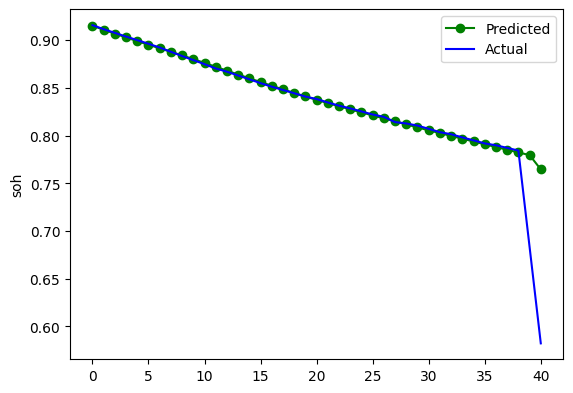

In [518]:
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
plt.plot(gru_outputs[0][-100:], "-o", color="g", label="Predicted")
plt.plot(targets[0][-100:], color="b", label="Actual")
plt.ylabel('soh')
plt.legend()